1) Скачать датасет https://github.com/phelber/EuroSAT?tab=readme-ov-file
2) Используя ArcFace Loss обучить нейронку (Resnet18) кодировать изображения  одного класса похожим образом (всего 10 классов ~3000 изображений на класс)
3) С помощью t-SNE визуализировать результаты работы (использовать тестовый датасет)
4) Визуализировать результаты работы (inference) в виде - пара изображений + distance

In [1]:
import os
import random

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np
from pytorch_metric_learning import losses

(64, 64, 3)


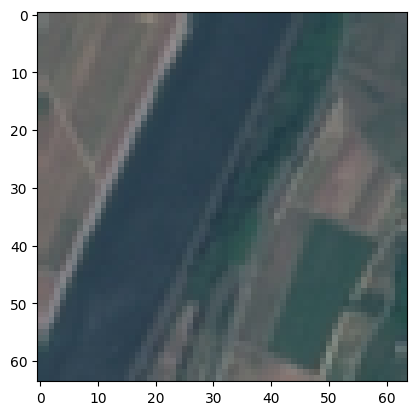

In [2]:
image = Image.open('dataset/River/River_1.jpg').convert("RGB")
plt.imshow(image)
print (np.array(image).shape)

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)  # List of class folders
        self.image_paths = []  # List of (image path, class index) tuples

        for class_id, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpg"):
                    self.image_paths.append((os.path.join(class_dir, image_name), class_id, class_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, class_id, class_name = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            transformed_image = self.transform(image)
        else:
            transformed_image = image  # If no transform, return original
        
        return transformed_image, class_id, class_name, image_path  # Now returns path too

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), # make sure the shape is (64, 64, 3)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalize
])

dataset = ImageDataset(root_dir='dataset', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, pin_memory_device='cuda:0')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, pin_memory_device='cuda:0')

In [5]:
model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print (torch.cuda.is_available())

/root/projects/2_lab_3/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/projects/2_lab_3/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True


In [6]:
# class ArcFaceLoss(nn.Module):
#     def __init__(self, num_classes, embedding_size, margin=0.5, scale=64.0):
#         super(ArcFaceLoss, self).__init__()
#         self.margin = margin
#         self.scale = scale
#         self.weights = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
#         nn.init.xavier_uniform_(self.weights)

#     def forward(self, embeddings, labels):
#         embeddings = F.normalize(embeddings, p=2, dim=1).to(device)
#         weights = F.normalize(self.weights, p=2, dim=1).to(device)

#         logits = F.linear(embeddings, weights)
#         return logits

In [8]:
num_classes = 10
embedding_size = 128
num_epochs = 10

# criterion = ArcFaceLoss(num_classes, embedding_size)
criterion = losses.ArcFaceLoss(num_classes, embedding_size, margin=0.5, scale=64)
loss_optimizer = torch.optim.SGD(criterion.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels, _, _ in train_loader:
        images, labels = images.to(device), labels.to(device)

        embeddings = model(images).to(device)
        loss = criterion(embeddings, labels)

        # loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_optimizer.step()

        running_loss += loss.item()

        with torch.no_grad():
            weight = criterion.W  # shape: (embedding_size, num_classes)
            
            # normalize
            normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
            normalized_weight = F.normalize(weight, p=2, dim=0)
            
            logits = torch.matmul(normalized_embeddings, normalized_weight) # compute cosine similarity (same as dot product when normalized)
            
            # Get predicted class
            _, predicted = torch.max(logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch [1/10], Loss: 0.7594, Accuracy: 0.8401
Epoch [2/10], Loss: 0.3788, Accuracy: 0.9087
Epoch [3/10], Loss: 0.2890, Accuracy: 0.9301
Epoch [4/10], Loss: 0.2633, Accuracy: 0.9356
Epoch [5/10], Loss: 0.2149, Accuracy: 0.9475
Epoch [6/10], Loss: 0.1985, Accuracy: 0.9509
Epoch [7/10], Loss: 0.1810, Accuracy: 0.9555
Epoch [8/10], Loss: 0.1505, Accuracy: 0.9632
Epoch [9/10], Loss: 0.1301, Accuracy: 0.9681
Epoch [10/10], Loss: 0.1264, Accuracy: 0.9693


In [9]:
embeddings = []
labels_show = []
model.eval()
with torch.no_grad():
    for images, labels, label_names, _ in test_loader:
        images = images.to(device)
        embeddings.append(model(images).cpu().numpy())
        labels_show.extend(label_names)

embeddings = np.concatenate(embeddings)

print((tuple (label) for label in labels_show))

tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(embeddings)

<generator object <genexpr> at 0x7fe61a467510>


In [10]:
torch.save(model, 'arcfacetask.pth')
print("Model saved to: arcfacetask.pth")

Model saved to: arcfacetask.pth


In [12]:
print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Embeddings shape: (5400, 2)
Labels shape: torch.Size([24])


Label AnnualCrop has 606 points
Label Forest has 618 points
Label HerbaceousVegetation has 568 points
Label Highway has 490 points
Label Industrial has 493 points
Label Pasture has 412 points
Label PermanentCrop has 492 points
Label Residential has 627 points
Label River has 490 points
Label SeaLake has 604 points


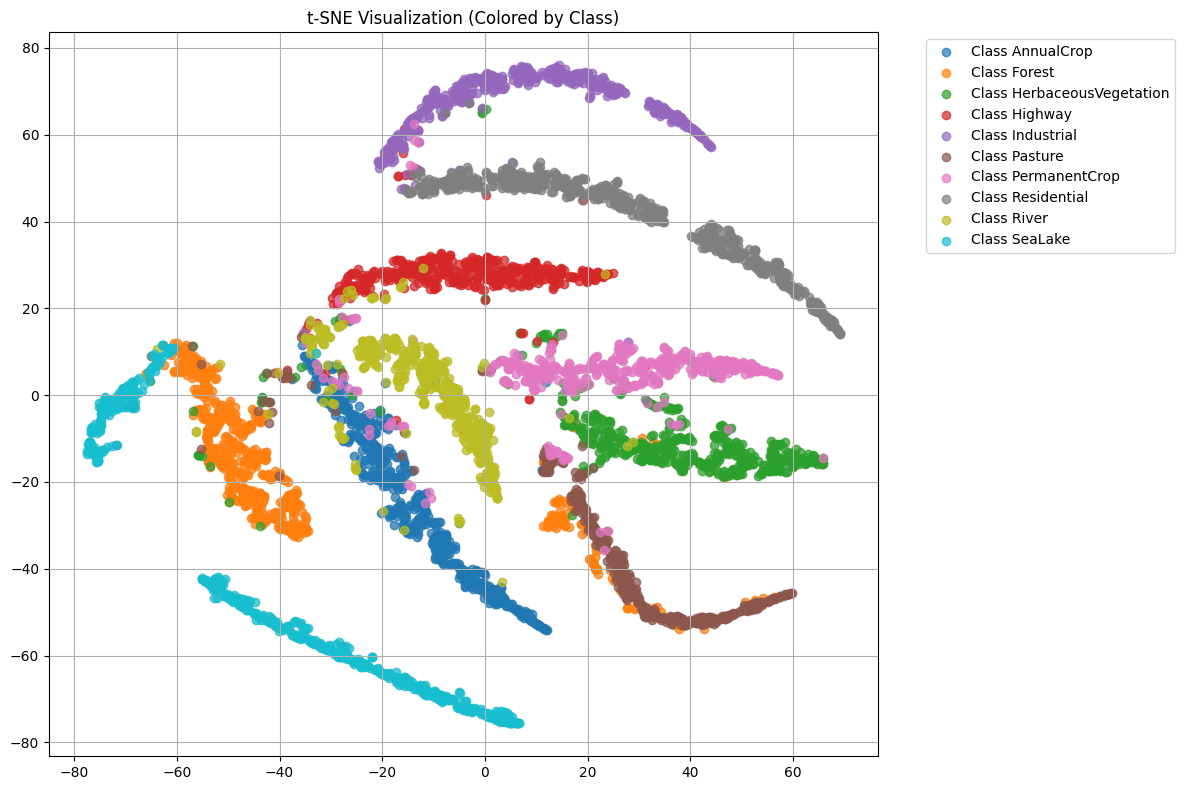

In [13]:
plt.figure(figsize=(12, 8))

if torch.is_tensor(embeddings):
    embeddings = embeddings.detach().cpu().numpy()
if torch.is_tensor(labels_show):
    labels_show = labels_show.detach().cpu().numpy()

labels_show = np.array(labels_show)

plt.scatter(embeddings[:, 0], embeddings[:, 1], 
            c='lightgray', alpha=0.3, label='_nolegend_')

for label in np.unique(labels_show):
    mask = labels_show == label
    if isinstance(mask, np.ndarray): 
        print(f"Label {label} has {np.sum(mask)} points") 
        if np.sum(mask) > 0:
            plt.scatter(embeddings[mask, 0], embeddings[mask, 1],
                       label=f'Class {label}',
                       alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Visualization (Colored by Class)")
plt.grid(True)
plt.tight_layout()
plt.show()

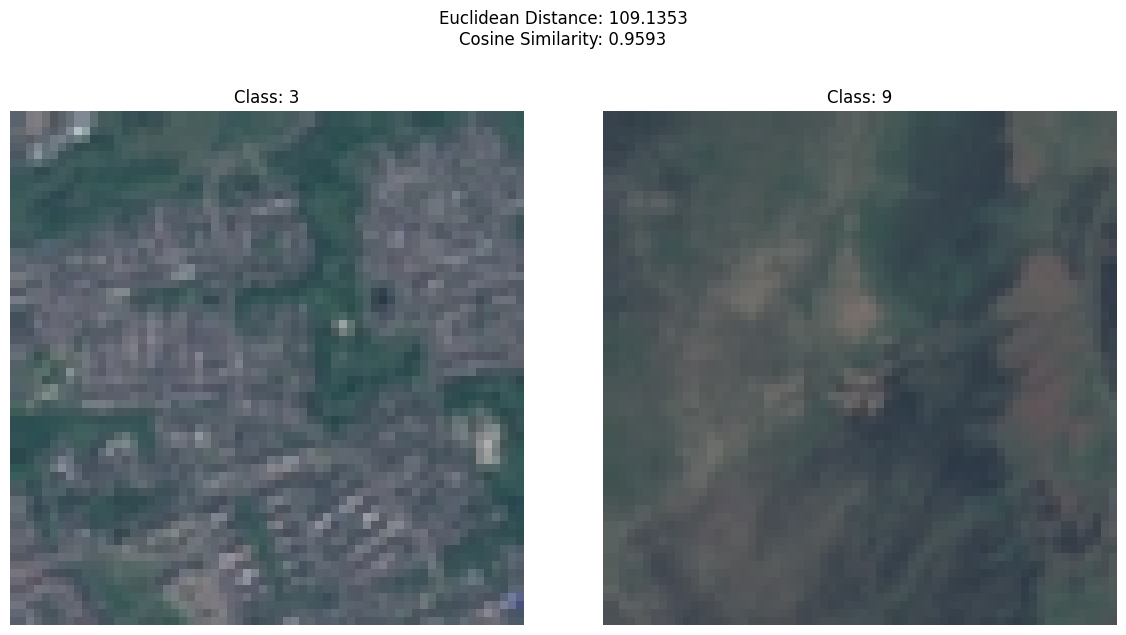

In [17]:
sample1 = random.choice(test_dataset)
sample2 = random.choice(test_dataset)

image1, label1 = sample1[0], sample1[1]
image2, label2 = sample2[0], sample2[1]

with torch.no_grad():
    embedding1 = model(image1.unsqueeze(0).to(device))
    embedding2 = model(image2.unsqueeze(0).to(device))

euclidean_dist = torch.norm(embedding1 - embedding2).item()
cosine_sim = torch.nn.functional.cosine_similarity(embedding1, embedding2).item()

plt.figure(figsize=(12, 6))

img1 = Image.open(sample1[3]).convert("RGB")
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title(f"Class: {label1}")
plt.axis('off')

img2 = Image.open(sample2[3]).convert("RGB")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title(f"Class: {label2}")
plt.axis('off')

plt.suptitle(
    f"Euclidean Distance: {euclidean_dist:.4f}\n"
    f"Cosine Similarity: {cosine_sim:.4f}",
    y=1.05
)
plt.tight_layout()
plt.show()